# Word Mover’s Distance

This notebook implements the **Word Mover's Distance (WMD)** as described in **[From Word Embeddings To Document Distances](http://proceedings.mlr.press/v37/kusnerb15.pdf)** by Matt Kusner, Yu Sun, Nicholas Kolkin and Kilian Weinberger.

## WMD
### Definition

The  **WMD**  measures the dissimilarity between two text documents as the minimum amount of distance that the  embedded  words  of  one  document  need  to “travel” to reach the embedded words of another document.

The problem is formulated as a transportation problem that is the minimal cumulative cost of moving $d$ to $d'$ given constraints. The solution is provided by the following linear program: 

$$\min_{T \geq 0} \sum_{i,j=1}^{n} T_{ij}c(i,j)$$

subject to $$  \sum_{j=1}^{n} T_{ij} = d_i,  \forall i \in \{1, ..., n\} $$
$$  \sum_{i=1}^{n} T_{ij} = d'_i,  \forall j \in \{1, ..., n\} $$

### Problem 

This solution is exact but requires heavy computations and usually use solvers that solve a **special case** of the **Earth Mover's Distance**.

As such, this notebook will go through several **faster approximate ways of computing WMD**.

# Implementation

## Importing libraries

We'll be using a few libraries to help with the implemention:

* **Gensim**: Preprocessing, word2vec, nBOW and the wmdistance function
* **Numpy**:  General numerical computing
* **Matplotlib**: Display curves and perf statistics
* **Time/Timeit**: Timing and benchmarks

In [1]:
import gensim.parsing.preprocessing as genproc

from gensim.utils import deaccent
from gensim.models import KeyedVectors
from gensim.models.normmodel import NormModel
from gensim import corpora

import numpy as np

import time
import timeit

C:\Users\cpcdo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Sentences

Let's load a few documents containing sentences that we'll use throughout this notebook.

In [2]:
f_strs = open("data/test_sentences.txt", "r", encoding='utf-8')
strs = [str for str in f_strs.readlines()]
strs

['Obama speaks to the media in Illinois\n',
 'The President greets the press in Chicago.\n',
 'Orange Prize winner Andrea Levy has seen her book Small Island win the Whitbread Novel of the Year Award.\n',
 "Sonia President has indicated that she would like to participate in next month's World Cross Country Championships in St Etienne.\n",
 "The President's firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n",
 'Denmark is holding a three-day celebration of the life of the fairy-tale author, with a concert at Parken stadium on 2 April. Other stars are expected to join the line-up in the coming months, and the Danish royal family will attend. "Christian Andersen\'s fairy tales are timeless and universal," said Jarre. "For all

## Preprocessing

This section preprocesses the text so that it can be used for our computations

### Stopwords, punctuation, spaces removal

Stopwords are words which are filtered out which do not really contribute to the meaning of a sentence. Stopwords examples are:

* “the”
* “a”
* “an”
* “in”

We also remove every other unnecessary things from the text like whitespaces, punctuation, short words, etc. 

In [4]:
proc = [genproc.remove_stopwords, 
    genproc.strip_tags,
    genproc.strip_punctuation,
    genproc.strip_multiple_whitespaces,
    genproc.strip_numeric,
    genproc.remove_stopwords,
    genproc.strip_short,
    deaccent]
    #genproc.stem_text]

def apply_lambdas(x, lambdas):
    return [p(x) for p in lambdas][-1]

In [5]:
strs_proc = [genproc.preprocess_string(str, proc) for str in strs]
strs_bbc_proc = [genproc.preprocess_string(str, proc) for str in strs_bbc]

## nBOW

Normalized Bag-of-word (BOW) 

In [6]:
dict = corpora.Dictionary()
bows = [dict.doc2bow(str, allow_update=True) for str in strs_proc]
print(dict.num_pos)

726


In [7]:
dict_bbc = corpora.Dictionary()
bows_bbc = [dict.doc2bow(str, allow_update=True) for str in strs_bbc_proc]
print(dict_bbc.num_pos)

0


In [8]:
def get_from_tuples(tuples, i, bows=bows):
    l = [[t[1]] * b[1] for (b, t) in zip(bows[i], tuples)]
    return [x for sub in l for x in sub]

In [9]:
norm_model = NormModel(norm='l1')
nbows_simple = [get_from_tuples(norm_model.normalize(bows[i]), i) for i in range(len(strs_proc))]

In [10]:
nbows_bbc = [get_from_tuples(norm_model.normalize(bows_bbc[i]), i, bows_bbc) for i in range(len(strs_bbc_proc))]

## word2vec

In [11]:
model = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [12]:
model.init_sims(replace=True)

### Set current dataset

In [13]:
#nbows = nbows_bbc
nbows = nbows_simple
strs_proc_simple = strs_proc
#strs_proc = strs_bbc_proc
strs_proc = strs_proc_simple

### Distances cache

In [14]:
class bidir_dict():
    def __init__(self):
        self.dict = {}
    def __len__(self):
        return self.dict.__len__(self) / 2

    def __setitem__(self, key, value):
        self.dict.__setitem__(key, value)
        
    def __getitem__(self, key):
        g = self.dict.get(key)
        if g == None:
            g = self.dict.get((key[1], key[0]))
        return g

dists = bidir_dict()

## WCD

### $WCD(d, d') = \left\lVert Xd - Xd' \right\rVert_2$

In [169]:
def get_centroid(doc):
    X = np.array([model[str] for str in strs_proc[doc]])
    d = np.array(nbows[doc])
    
    return X.T.dot(d)

In [170]:
def dist(x, y, i, j):
    return np.sqrt(np.sum((x - y)**2))

In [17]:
def dist(x, y, i, j):
    d = dists[(i, j)]
    if d == None:
        d = np.sqrt(np.sum((x - y)**2))
        dists[(i, j)] = d
    return d

In [171]:
def wcd(doc1, doc2):
    c1 = get_centroid(doc1)
    c2 = get_centroid(doc2)
    return dist(c1, c2, doc1, doc2)

In [172]:
[wcd(0, i) for i in range(len(nbows))]

[0.0,
 0.4889688754349564,
 0.6282021317744428,
 0.607863411337698,
 0.6216390672798184,
 0.5685506211966792,
 0.634117029062517,
 0.6086501006435308,
 2.294856610359048,
 0.8530214259104537,
 0.8912037390990674,
 0.8495958119706942,
 0.740203290171906,
 0.6066595381454836,
 0.765175278237766,
 0.6506489116202538,
 0.6153644479910629,
 0.7279378379077874,
 0.6405168303900033,
 0.6178455141858197,
 0.5810393113521084,
 0.679971016715287]

In [173]:
strs_proc

[['Obama', 'speaks', 'media', 'Illinois'],
 ['The', 'President', 'greets', 'press', 'Chicago'],
 ['Orange',
  'Prize',
  'winner',
  'Andrea',
  'Levy',
  'seen',
  'book',
  'Small',
  'Island',
  'win',
  'Whitbread',
  'Novel',
  'Year',
  'Award'],
 ['Sonia',
  'President',
  'indicated',
  'like',
  'participate',
  'month',
  'World',
  'Cross',
  'Country',
  'Championships',
  'Etienne'],
 ['The',
  'President',
  'firm',
  'biggest',
  'investors',
  'Google',
  'benefited',
  'sales',
  'high',
  'speed',
  'internet',
  'connections',
  'higher',
  'advert',
  'sales',
  'TimeWarner',
  'said',
  'fourth',
  'quarter',
  'sales',
  'rose',
  'Its',
  'profits',
  'buoyed',
  'gains',
  'offset',
  'profit',
  'dip',
  'Warner',
  'Bros',
  'users',
  'AOL'],
 ['Denmark',
  'holding',
  'day',
  'celebration',
  'life',
  'fairy',
  'tale',
  'author',
  'concert',
  'Parken',
  'stadium',
  'April',
  'Other',
  'stars',
  'expected',
  'join',
  'line',
  'coming',
  'month

## Relaxed WMD

In [174]:
def rwmd_implem_1(doc1, doc2):
    X = model
    idx = 0
    rwmd1 = 0
    for j in strs_proc[doc1]:
        c_ij = [dist(X[j], X[i], i, j) for i in strs_proc[doc2]]
        rwmd1 += min(c_ij) * nbows[doc1][idx]
        idx += 1
    idx = 0
    rwmd2 = 0
    for j in strs_proc[doc2]:
        c_ij = [dist(X[j], X[i], i, j) for i in strs_proc[doc1]]
        rwmd2 += min(c_ij) * nbows[doc2][idx]
        idx += 1
        
    return max(rwmd1, rwmd2)

def rwmd_implem_2(doc1, doc2):
    doc1_len = len(nbows[doc1])
    doc2_len = len(nbows[doc2])
    doc1_dists = np.ones(doc1_len) * float('inf')
    doc2_dists = np.ones(doc2_len) * float('inf')
    
    dists = np.array([[dist(model[i], model[j], i, j) for j in strs_proc[doc2]] for i in strs_proc[doc1]])
    
    for word1_index in range(doc1_len):
        word1 = strs_proc[doc1][word1_index]
        for word2_index in range(doc2_len):
            word2 = strs_proc[doc2][word2_index]
            wdist = dists[word1_index][word2_index] 
            
            if wdist < doc1_dists[word1_index]:
                doc1_dists[word1_index] = wdist
            if wdist < doc2_dists[word2_index]:
                doc2_dists[word2_index] = wdist
    
    rwmd1 = np.sum(doc1_dists * nbows[doc1])
    rwmd2 = np.sum(doc2_dists * nbows[doc2])
    rwmd = max(rwmd1, rwmd2)
    return rwmd

def rwmd(doc1, doc2):
    doc1_len = len(nbows[doc1])
    doc2_len = len(nbows[doc2])
    
    dists = np.array([[dist(model[i], model[j], i, j) for j in strs_proc[doc2]] for i in strs_proc[doc1]])
    
    c_ij = np.array([np.min([dists[i][j] for j in range(doc2_len)]) for i in range(doc1_len)])
    rwmd1 = np.dot(c_ij, nbows[doc1])
    c_ij = np.array([np.min([dists[j][i] for j in range(doc1_len)]) for i in range(doc2_len)])
    rwmd2 = np.dot(c_ij, nbows[doc2])
    
    return max(rwmd1, rwmd2)

In [175]:
#%timeit rwmd(6, 7)

In [176]:
#%timeit rwmd_implem_1(9, 10)

In [177]:
#%timeit rwmd_implem_2(9, 10)

In [178]:
#%timeit wcd(9, 10)

In [179]:
start = time.perf_counter()
wcd(0, 5)
end = time.perf_counter()
end - start

0.000900626000657212

In [27]:
#%timeit model.wmdistance(strs_proc[6], strs_proc[7])

In [28]:
start = time.perf_counter()
model.wmdistance(strs_proc[0], strs_proc[5])
end = time.perf_counter()
end - start

0.02722439699999768

In [29]:
[rwmd_implem_1(0, j) for j in range(len(nbows))]

[0.0,
 1.0618066430091857,
 1.3466628619602747,
 1.3384341543371028,
 1.5745622590184212,
 1.6217780970945592,
 2.0408487006237634,
 2.1576749499963253,
 3.3718802332878113,
 1.3447080850601196,
 1.3566317558288574,
 1.3516850173473358,
 1.3274114429950714,
 1.3285035490989685,
 1.3340416848659515,
 1.336386799812317,
 1.7221189198955411,
 1.341009497642517,
 1.2823150591416792,
 1.7546531072882716,
 1.529034259142699,
 2.212308130985082]

In [30]:
[rwmd_implem_2(0, j) for j in range(len(nbows))]

[0.0,
 1.0618066430091857,
 1.3466628619602747,
 1.3384341543371028,
 1.5745622590184212,
 1.621778097094559,
 2.040848700623763,
 2.1576749499963253,
 3.3718802332878113,
 1.3447080850601196,
 1.3566317558288574,
 1.3516850173473358,
 1.3274114429950714,
 1.3285035490989683,
 1.3340416848659515,
 1.336386799812317,
 1.7221189198955411,
 1.341009497642517,
 1.2823150591416792,
 1.7546531072882718,
 1.5290342591426989,
 2.2123081309850825]

In [31]:
[rwmd(0, j) for j in range(len(nbows))]

[0.0,
 1.0618066430091857,
 1.3466628619602747,
 1.3384341543371028,
 1.5745622590184212,
 1.621778097094559,
 2.040848700623763,
 2.1576749499963253,
 3.3718802332878113,
 1.3447080850601196,
 1.3566317558288574,
 1.3516850173473358,
 1.3274114429950714,
 1.3285035490989685,
 1.3340416848659515,
 1.336386799812317,
 1.7221189198955411,
 1.341009497642517,
 1.2823150591416792,
 1.7546531072882718,
 1.5290342591426989,
 2.2123081309850825]

In [32]:
[wcd(0, j) for j in range(len(nbows))]

[0.0,
 0.4889688754349564,
 0.6282021317744428,
 0.607863411337698,
 0.6216390672798184,
 0.5685506211966792,
 0.634117029062517,
 0.6086501006435308,
 2.294856610359048,
 0.8530214259104537,
 0.8912037390990674,
 0.8495958119706942,
 0.740203290171906,
 0.6066595381454836,
 0.765175278237766,
 0.6506489116202538,
 0.6153644479910629,
 0.7279378379077874,
 0.6405168303900033,
 0.6178455141858197,
 0.5810393113521084,
 0.679971016715287]

In [33]:
[model.wmdistance(strs_proc[0], strs_proc[j]) for j in range(len(nbows))]

[0.0,
 1.064594336759162,
 1.3496657413730007,
 1.3449191373622853,
 1.3251857828273477,
 1.3280674600887181,
 1.3242448895635275,
 1.3229613969767622,
 1.3779413764327169,
 1.3515102978463174,
 1.361813734663129,
 1.356589825306803,
 1.3329633577233069,
 1.3359622712908688,
 1.338013213535734,
 1.338700849033177,
 1.3339357248328365,
 1.3578414765372275,
 1.2851774315077849,
 1.3284418756421288,
 1.326301286976676,
 1.323848357715634]

## Prefetch and Prune

In [180]:
def wmd_prefetch_prune(doc, doc_list, k, m):
    if k < m:
        k = m
    elif k > len(doc_list):
        k = len(doc_list)
    doc_list_sorted = doc_list
    doc_list_sorted.sort(key=lambda x: wcd(doc, x))
    doc_list_sorted = np.array(doc_list_sorted)
    #print(doc_list_sorted)
    
    nearest_neighbors = [None] * m
    nearest_distances = [float("inf")] * m

    idx = 0
    push_off = 0
    for curr_doc in doc_list_sorted[:k]:
        rwmd_dist = 0
        
        if idx >= m:
            rwmd_dist = rwmd(doc, curr_doc)
            #print("b")
            #print("curr_doc >= k", curr_doc, rwmd_dist)

        if rwmd_dist < nearest_distances[0]:
            neighbor_number = 0
            wmd_dist = model.wmdistance(strs_proc[doc], strs_proc[curr_doc])
            #print("a")
            #print("rwmd < nn dist", rwmd_dist, "<", nearest_distances[0])
            #print("wmd", wmd_dist)
            #while wmd_dist < nearest_distances[neighbor_number]:
            #    neighbor_number += 1
            #    if neighbor_number >= len(nearest_distances):
            #        break
    
            w = np.sum(wmd_dist < np.array(nearest_distances))
            #print("W,", w, w)
            neighbor_number = min(w, k)
            #print(neighbor_number, n_number)
            if neighbor_number > 0:
                #print(neighbor_number)
                nearest_distances.insert(neighbor_number, wmd_dist)
                nearest_neighbors.insert(neighbor_number, curr_doc)
                
                nearest_neighbors.pop(0)
                nearest_distances.pop(0)
                
            #print("NNs", nearest_neighbors)
            #print("NNs dists", nearest_distances)
        idx += 1
    #print(nearest_distances)
    return nearest_neighbors[-k:]

In [52]:
wmd_nn = [wmd_prefetch_prune(idx, [i for i in range(len(strs_proc))], 9, 9) for idx in range(len(strs_proc))]
wmd_nn

[[3, 13, 16, 19, 5, 20, 7, 1, 0],
 [13, 18, 16, 20, 5, 7, 3, 0, 1],
 [18, 20, 3, 5, 16, 15, 7, 13, 2],
 [20, 2, 7, 5, 15, 19, 16, 13, 3],
 [2, 3, 18, 5, 19, 16, 20, 6, 4],
 [13, 2, 3, 15, 19, 20, 16, 7, 5],
 [18, 19, 7, 5, 16, 21, 20, 4, 6],
 [13, 3, 2, 15, 19, 20, 16, 5, 7],
 [7, 5, 6, 16, 4, 21, 20, 9, 8],
 [7, 20, 2, 4, 16, 5, 3, 13, 9],
 [20, 2, 16, 3, 19, 7, 5, 11, 10],
 [3, 2, 16, 19, 7, 5, 20, 10, 11],
 [20, 5, 7, 3, 2, 16, 15, 13, 12],
 [20, 5, 7, 2, 16, 15, 3, 12, 13],
 [20, 2, 7, 3, 5, 13, 16, 15, 14],
 [20, 2, 7, 5, 3, 13, 16, 14, 15],
 [2, 13, 20, 6, 3, 7, 5, 15, 16],
 [3, 16, 2, 13, 5, 4, 20, 18, 17],
 [2, 5, 16, 3, 6, 4, 20, 19, 18],
 [7, 3, 16, 5, 6, 18, 21, 20, 19],
 [18, 16, 7, 5, 6, 4, 21, 19, 20],
 [4, 18, 7, 16, 6, 5, 19, 20, 21]]

In [36]:
a = np.array([i for i in range(len(strs_proc))])
wmd_k_first = [[model.wmdistance(strs_proc[idx], strs_proc[j]) for j in a] for idx in range(len(strs_proc))]
wmd_k_first = a[np.argsort(wmd_k_first)][:, :7]
print(wmd_k_first)

[[ 0  1 18  7 21  6  4]
 [ 1  0  3  4  7  5 20]
 [ 2 13  7 15 16  5  3]
 [ 3 13 16 19  1 15  5]
 [ 4  6 20 16 19  7  5]
 [ 5  7 16 21 20  6 19]
 [ 6  4 20 21 16  5  7]
 [ 7  5 16 20  6 21 19]
 [ 8  9 10 20 11 21  4]
 [ 9  8 10 11  1  0 12]
 [10 11  5  9  8  7 19]
 [11 10  9 20  5  7  8]
 [12 13 14 15 16  2  3]
 [13 12  3 15 16  2  7]
 [14 15 16 12 13 19  5]
 [15 14 16 13  3  5  7]
 [16 15  5  7  3  6 14]
 [17 18 20 19  4  6  5]
 [18 19 20 21  4  6  3]
 [19 20 21 18  6  5 16]
 [20 19 21  4  6  5  7]
 [21 20 19  5  6 16  7]]


In [37]:
acc_score = 0
for d1, d2 in zip(wmd_nn, wmd_k_first):
    d1 = np.array(d1)
    index = np.in1d(d2, d1)
    #print(d1, d2)
    #print(index)
    score = np.sum(index == True) / len(d1)
    print(score)
    acc_score += score
print("Final score:", acc_score / len(wmd_nn))

0.42857142857142855
0.8571428571428571
0.8571428571428571
0.5714285714285714
0.7142857142857143
0.5714285714285714
0.8571428571428571
0.5714285714285714
0.7142857142857143
0.14285714285714285
0.7142857142857143
0.7142857142857143
0.8571428571428571
0.8571428571428571
0.7142857142857143
0.8571428571428571
0.7142857142857143
0.7142857142857143
0.7142857142857143
0.8571428571428571
0.8571428571428571
1.0
Final score: 0.7207792207792207


# Performances

In [38]:
import matplotlib.pyplot as plt

In [181]:
def time_func(fn=rwmd, nb_docs=10, nb_iter=10):
    timing_data = np.zeros((nb_docs - 1, 2))
    for i in range(nb_docs - 1):
        if fn == model.wmdistance:
            def f():
                model.wmdistance(strs_proc[i], strs_proc[i + 1])
        else:
            def f():
                fn(i, i + 1)
        
        timing_data[i][0], _ = timeit.Timer(f, 'gc.enable()').timeit(number=nb_iter)
        timing_data[i][1] = len(strs_proc[i]) + len(strs_proc[i + 1])
    
    return timing_data

In [184]:
funcs = [wcd, rwmd_implem_1, rwmd_implem_2, rwmd, model.wmdistance]
data = np.array([time_func(i, len(strs_proc), 100) for i in funcs])

In [185]:
data_no_cache = np.array([time_func(i, len(strs_proc), 100) for i in funcs[:-1]])

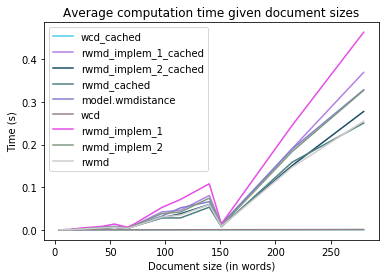

In [193]:
x = data[0, :, 1]
fn_names = ["wcd", "rwmd_implem_1", "rwmd_implem_2", "rwmd", "model.wmdistance"]

x_args = np.argsort(x)

fig, ax = plt.subplots()
for i in range(data.shape[0]):
    ax.plot(x[x_args], data[i, x_args, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=str(fn_names[i]+ ('' if i == len(fn_names) - 1 else '_cached')))
for i in range(data_no_cache.shape[0]):
    ax.plot(x[x_args], data_no_cache[i, x_args, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=fn_names[i])

ax.legend()

ax.set_xlabel('Document size (in words)')
ax.set_ylabel('Time (s)')
ax.set_title('Average computation time given document sizes')
plt.show()

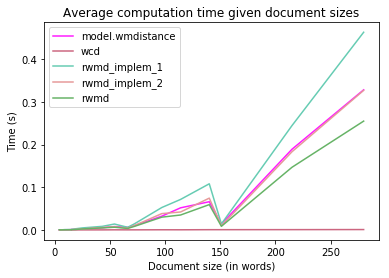

In [204]:
x = data[0, :, 1]
fn_names = ["wcd", "rwmd_implem_1", "rwmd_implem_2", "rwmd", "model.wmdistance"]

x_args = np.argsort(x)

fig, ax = plt.subplots()
i = data.shape[0] - 1
ax.plot(x[x_args], data[i, x_args, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=fn_names[i])

for i in range(data_no_cache.shape[0]):
    ax.plot(x[x_args], data_no_cache[i, x_args, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=fn_names[i])

ax.legend()

ax.set_xlabel('Document size (in words)')
ax.set_ylabel('Time (s)')
ax.set_title('Average computation time given document sizes')
plt.show()

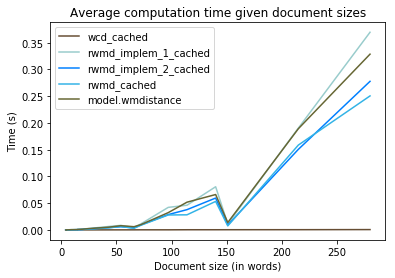

In [207]:
x = data[0, :, 1]
fn_names = ["wcd", "rwmd_implem_1", "rwmd_implem_2", "rwmd", "model.wmdistance"]

x_args = np.argsort(x)

fig, ax = plt.subplots()
for i in range(data.shape[0]):
    ax.plot(x[x_args], data[i, x_args, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=fn_names[i] + ('' if i == len(fn_names) - 1 else '_cached'))

ax.legend()

ax.set_xlabel('Document size (in words)')
ax.set_ylabel('Time (s)')
ax.set_title('Average computation time given document sizes')
plt.show()

## Multiple documents

In [43]:
def wmd_prefetch_prune_test(k, m):
    return [wmd_prefetch_prune(idx, [i for i in range(len(strs_proc))], k, m) for idx in range(len(strs_proc))]

In [44]:
def wmdistance_test():
    a = np.array([i for i in range(len(strs_proc))])
    wmd_k_first = [[model.wmdistance(strs_proc[idx], strs_proc[j]) for j in a] for idx in range(len(strs_proc))]
    return a[np.argsort(wmd_k_first)][:, :7]

In [45]:
timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

In [46]:
def calc_wmd_score(wmd_nn, wmd_k_first): 
    acc_score = 0
    for d1, d2 in zip(wmd_nn, wmd_k_first):
        d1 = np.array(d1)
        index = np.in1d(d2, d1)
        score = np.sum(index == True) / len(d1)
        acc_score += score
    return acc_score / len(wmd_nn)

In [49]:
def time_func_mul_docs(k_max=3, m_max=3, nb_iter=10):
    timing_data = np.zeros((k_max, m_max, 2, 3))
    ret1 = []
    for k in range(k_max):
        for m in range(1, m_max):
            for i in range(2):
                if i == 1:
                    def f():
                        a = np.array([i for i in range(len(strs_proc))])
                        wmd_k_first = [[model.wmdistance(strs_proc[idx], strs_proc[j]) for j in a] for idx in range(len(strs_proc))]
                        return a[np.argsort(wmd_k_first)][:, :m]
                else:
                    def f():
                        return [wmd_prefetch_prune(idx, [i for i in range(len(strs_proc))], k, m) for idx in range(len(strs_proc))]
                
                #timing_data[i][0] = timeit.timeit(f, number=nb_iter)
                print(k, m, i, timing_data.shape)
                timing_data[k, m, i, 0], ret = timeit.Timer(f, 'gc.enable()').timeit(number=nb_iter)
                if i == 0:
                    ret1 = ret
                else:
                    timing_data[k, m, i, 2] = calc_wmd_score(ret, ret1)
                    print("score:", timing_data[k, m, i, 2])
                timing_data[k, m, i, 1] = len(strs_proc[i]) + len(strs_proc[i + 1])
    
    return timing_data

In [50]:
data = time_func_mul_docs(10, 10, 10)

0 1 0 (10, 10, 2, 3)
0 1 1 (10, 10, 2, 3)
score: 1.0
0 2 0 (10, 10, 2, 3)
0 2 1 (10, 10, 2, 3)
score: 0.8181818181818182
0 3 0 (10, 10, 2, 3)
0 3 1 (10, 10, 2, 3)
score: 0.7878787878787876
0 4 0 (10, 10, 2, 3)
0 4 1 (10, 10, 2, 3)
score: 0.6931818181818182
0 5 0 (10, 10, 2, 3)
0 5 1 (10, 10, 2, 3)
score: 0.7000000000000001
0 6 0 (10, 10, 2, 3)
0 6 1 (10, 10, 2, 3)
score: 0.7045454545454546
0 7 0 (10, 10, 2, 3)
0 7 1 (10, 10, 2, 3)
score: 0.7207792207792207
0 8 0 (10, 10, 2, 3)
0 8 1 (10, 10, 2, 3)
score: 0.7329545454545454
0 9 0 (10, 10, 2, 3)
0 9 1 (10, 10, 2, 3)
score: 0.7777777777777779
1 1 0 (10, 10, 2, 3)
1 1 1 (10, 10, 2, 3)
score: 1.0
1 2 0 (10, 10, 2, 3)
1 2 1 (10, 10, 2, 3)
score: 0.8181818181818182
1 3 0 (10, 10, 2, 3)
1 3 1 (10, 10, 2, 3)
score: 0.7878787878787876
1 4 0 (10, 10, 2, 3)
1 4 1 (10, 10, 2, 3)
score: 0.6931818181818182
1 5 0 (10, 10, 2, 3)
1 5 1 (10, 10, 2, 3)
score: 0.7000000000000001
1 6 0 (10, 10, 2, 3)
1 6 1 (10, 10, 2, 3)
score: 0.7045454545454546
1 7 0 (10,

[1.         0.81818182 0.78787879 0.69318182 0.7        0.70454545
 0.72077922 0.73295455 0.77777778]


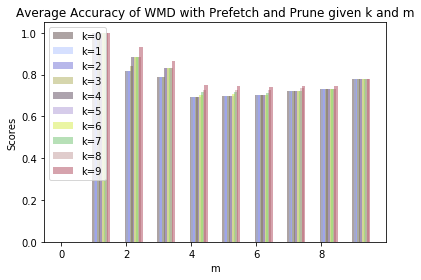

In [152]:
error_config = {'ecolor': '0.3'}
fig, ax = plt.subplots()

for i in range(data.shape[0]):
    ax.bar(np.arange(data.shape[0]) + 0.05*i, data[i, :, 1, 2], 0.1,
                alpha=0.4, color=np.around(np.random.rand(3, 1), 1).flatten(),
                 error_kw=error_config,
                label='k=' + str(i))

ax.legend()

ax.set_xlabel('m')
ax.set_ylabel('Scores')
ax.set_title('Average Accuracy of WMD with Prefetch and Prune given k and m')

fig.tight_layout()
plt.show()

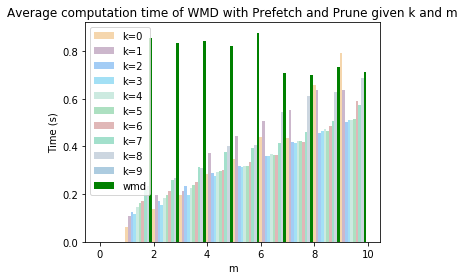

In [130]:
error_config = {'ecolor': '0.3'}
fig, ax = plt.subplots()

for i in range(data.shape[0]):
    ax.bar(np.arange(data.shape[0]) + 0.1*i, data[i, :, 0, 0] / 100, 0.1,
                alpha=0.4, color=np.around(np.random.rand(3, 1), 1).flatten(),
                 error_kw=error_config,
                label='k=' + str(i))

ax.bar(np.arange(data.shape[0]) + 0.1*i, data[i, :, 1, 0] / 100, 0.1,
                alpha=1.0, color='g',
                 error_kw=error_config,
                label='wmd')

ax.legend()

ax.set_xlabel('m')
ax.set_ylabel('Time (s)')
ax.set_title('Average computation time of WMD with Prefetch and Prune given k and m')

fig.tight_layout()
plt.show()